In [124]:
!apt-get update
!apt-get install git

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Reading package lists... Done
Reading package lists... Done
Building dependency t

In [125]:
!git clone https://github.com/Hamster-yang/ai_captcha.git

fatal: destination path 'ai_captcha' already exists and is not an empty directory.


In [132]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import random

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Layer, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Input 
from tensorflow.keras.callbacks import EarlyStopping

import plotly.express as px
import plotly.graph_objects as go

import os

In [133]:
import string
captcha_list = []
img_shape = (30, 120, 1)
symbols = string.ascii_lowercase+ string.ascii_uppercase + "0123456789"

len_symbols = len(symbols) # the number of symbols
nSamples = len(os.listdir('/content/ai_captcha/train')) # the number of samples 'captchas'
len_captcha = 5

X = np.zeros((nSamples, 30, 120, 1)) # 1070 * 50 * 200
y = np.zeros((5, nSamples, len_symbols)) # 5 * 1070 * 36

nSamples_test = len(os.listdir('/content/ai_captcha/test')) # the number of samples 'captchas'

X_test1 = np.zeros((nSamples_test, 30, 120, 1)) # 1070 * 50 * 200
y_test1 = np.zeros((5, nSamples_test, len_symbols)) # 5 * 1070 * 36

In [ ]:
symbols

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

In [134]:
for i, captcha in enumerate(os.listdir('/content/ai_captcha/train')):
    captcha_code = captcha.split(".")[0]
    captcha_list.append(captcha_code)
    captcha_cv2 = cv2.imread(os.path.join('/content/ai_captcha/train', captcha), cv2.IMREAD_GRAYSCALE)

        
    captcha_cv2=cv2.resize(captcha_cv2,[300,100])
    kernel = np.ones((3,3), np.uint8)
    captcha_cv2=cv2.dilate(captcha_cv2,kernel,iterations = 1)
    ret,captcha_cv2=cv2.threshold(captcha_cv2,195,255,cv2.THRESH_BINARY)

    captcha_cv2=cv2.resize(captcha_cv2,[120,30])
    
    captcha_cv2 = captcha_cv2 / 255.0
    captcha_cv2 = np.reshape(captcha_cv2, img_shape)
    targs = np.zeros((len_captcha, len_symbols))
    
    for a, b in enumerate(captcha_code):
        targs[a, symbols.index(b)] = 1
    
    X[i] = captcha_cv2
    y[:, i] = targs

In [135]:
for i, captcha in enumerate(os.listdir('/content/ai_captcha/test')):
    captcha_code = captcha.split(".")[0]
    captcha_list.append(captcha_code)
    captcha_cv2 = cv2.imread(os.path.join('/content/ai_captcha/test', captcha), cv2.IMREAD_GRAYSCALE)

        
    captcha_cv2=cv2.resize(captcha_cv2,[300,100])
    kernel = np.ones((3,3), np.uint8)
    captcha_cv2=cv2.dilate(captcha_cv2,kernel,iterations = 1)
    ret,captcha_cv2=cv2.threshold(captcha_cv2,195,255,cv2.THRESH_BINARY)

    captcha_cv2=cv2.resize(captcha_cv2,[120,30])
    
    captcha_cv2 = captcha_cv2 / 255.0
    captcha_cv2 = np.reshape(captcha_cv2, img_shape)
    targs = np.zeros((len_captcha, len_symbols))
    
    for a, b in enumerate(captcha_code):
        targs[a, symbols.index(b)] = 1
    
    X_test1[i] = captcha_cv2
    y_test1[:, i] = targs

In [137]:
print("shape of X:", X.shape)
print("shape of y:", y.shape)
print("shape of X_test1:", X_test1.shape)
print("shape of y_test1:", y_test1.shape)

shape of X: (10000, 30, 120, 1)
shape of y: (5, 10000, 62)
shape of X_test1: (20000, 30, 120, 1)
shape of y_test1: (5, 20000, 62)


In [138]:
X_train = X[:10000] 
y_train = y[:, :10000]
X_test = X_test1[:20000]
y_test = y_test1[:, :20000]

In [139]:
captcha = Input(shape=(30,120,1))
x = Conv2D(16, (3,3),padding='same',activation='relu')(captcha)
x = MaxPooling2D((2,2) , padding='same')(x)
x = Conv2D(32, (3,3),padding='same',activation='relu')(x)
x = MaxPooling2D((2,2) , padding='same')(x)
x = Conv2D(32, (3,3),padding='same',activation='relu')(x)
x = MaxPooling2D((2,2) , padding='same')(x)
x = Conv2D(32, (3,3),padding='same',activation='relu')(x)
x = MaxPooling2D((2,2) , padding='same')(x)
x = BatchNormalization()(x)


flatOutput = Flatten()(x)

dense1 = Dense(64 , activation='relu')(flatOutput)
dropout1= Dropout(0.5)(dense1)
output1 = Dense(len_symbols , activation='sigmoid' , name='char_1')(dropout1)

dense2 = Dense(64 , activation='relu')(flatOutput)
dropout2= Dropout(0.5)(dense2)
output2 = Dense(len_symbols , activation='sigmoid' , name='char_2')(dropout2)
    
dense3 = Dense(64 , activation='relu')(flatOutput)
dropout3= Dropout(0.5)(dense3)
output3 = Dense(len_symbols , activation='sigmoid' , name='char_3')(dropout3)
    
dense4 = Dense(64 , activation='relu')(flatOutput)
dropout4= Dropout(0.5)(dense4)
output4 = Dense(len_symbols , activation='sigmoid' , name='char_4')(dropout4)
    
dense5 = Dense(64 , activation='relu')(flatOutput)
dropout5= Dropout(0.5)(dense5)
output5 = Dense(len_symbols , activation='sigmoid' , name='char_5')(dropout5)
    
model = Model(inputs = captcha , outputs=[output1 , output2 , output3 , output4 , output5])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
earlystopping = EarlyStopping(monitor ="val_loss",  
                             mode ="min", patience = 5,  
                             restore_best_weights = True) 

history = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=16, epochs=240, verbose=1, validation_split=0.2, )#callbacks =[earlystopping])

Epoch 1/240
500/500 [==============================] - 7s 10ms/step - loss: 20.5864 - char_1_loss: 4.1232 - char_2_loss: 4.1108 - char_3_loss: 4.1171 - char_4_loss: 4.1177 - char_5_loss: 4.1176 - char_1_accuracy: 0.0213 - char_2_accuracy: 0.0289 - char_3_accuracy: 0.0216 - char_4_accuracy: 0.0268 - char_5_accuracy: 0.0235 - val_loss: 20.3830 - val_char_1_loss: 4.0762 - val_char_2_loss: 4.0543 - val_char_3_loss: 4.0845 - val_char_4_loss: 4.0819 - val_char_5_loss: 4.0861 - val_char_1_accuracy: 0.0325 - val_char_2_accuracy: 0.0365 - val_char_3_accuracy: 0.0365 - val_char_4_accuracy: 0.0325 - val_char_5_accuracy: 0.0320
Epoch 2/240
500/500 [==============================] - 5s 9ms/step - loss: 19.3650 - char_1_loss: 3.7517 - char_2_loss: 3.8249 - char_3_loss: 3.9079 - char_4_loss: 3.9755 - char_5_loss: 3.9049 - char_1_accuracy: 0.0519 - char_2_accuracy: 0.0535 - char_3_accuracy: 0.0424 - char_4_accuracy: 0.0439 - char_5_accuracy: 0.0417 - val_loss: 18.2209 - val_char_1_loss: 3.4070 - val_c

In [112]:
score = model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)

print('Test Loss and accuracy:', score)

286/286 [==============================] - 2s 7ms/step - loss: 1.7052 - char_1_loss: 0.1721 - char_2_loss: 0.2935 - char_3_loss: 0.4917 - char_4_loss: 0.4694 - char_5_loss: 0.2784 - char_1_accuracy: 0.9676 - char_2_accuracy: 0.9512 - char_3_accuracy: 0.9208 - char_4_accuracy: 0.9053 - char_5_accuracy: 0.9507
Test Loss and accuracy: [1.7051615715026855, 0.17212316393852234, 0.29347801208496094, 0.49173402786254883, 0.46944889426231384, 0.2783777117729187, 0.967629075050354, 0.9512248635292053, 0.9208223819732666, 0.9052931070327759, 0.9506780505180359]


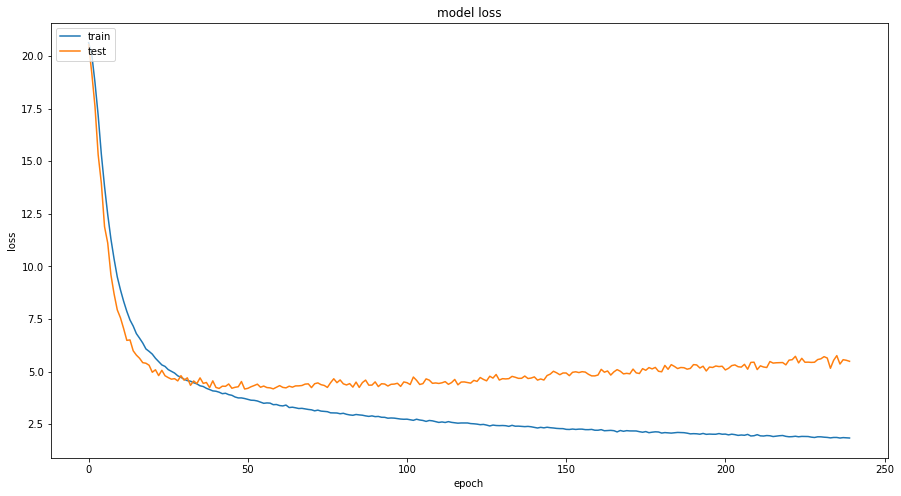

In [113]:
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def makePredict(captcha):
    captcha = np.reshape(captcha , (30,120))
    result = model.predict(np.reshape(captcha, (1,30,212000,1)))
    result = np.reshape(result ,(5,62))
    indexes =[]
    for i in result:
        indexes.append(np.argmax(i))
        
    label=''
    for i in indexes:
        label += symbols[i]
        
    return label

In [114]:
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    img=cv2.resize(img,[300,100])
    kernel = np.ones((3,3), np.uint8)
    img=cv2.dilate(img,kernel,iterations = 1)
    ret,img=cv2.threshold(img,195,255,cv2.THRESH_BINARY)

    img=cv2.resize(img,[120,30])


    if img is not None:
        img = img / 255.0
    else:
        print("Not detected")
        return '100000'
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 62))#-------------------------------------------------------
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5

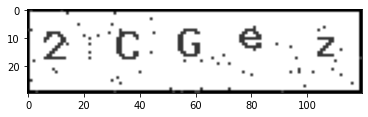

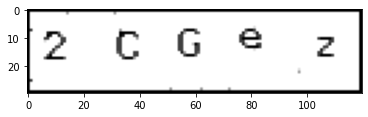

In [121]:
image = cv2.imread("/content/ai_captcha/test/2CGez.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image,cmap='gray')
plt.show()
image=cv2.resize(image,[300,100])
kernel = np.ones((3,3), np.uint8)
image=cv2.dilate(image,kernel,iterations = 1)
ret,image=cv2.threshold(image,195,255,cv2.THRESH_BINARY)

image1=cv2.resize(image,[120,30])
plt.imshow(image1,cmap='gray')

plt.show()

In [115]:


while(1):
    str_path ="/content/ai_captcha/test/" + input("path:")+ ".png"
    if str_path == 'qqq':
        break;
    str=predict(str_path)
    if str != '100000' :

        print(str)

path:06S3S
1/1 [==============================] - 0s 142ms/step
06S3S
path:0c9ge
1/1 [==============================] - 0s 20ms/step
0a399
path:1KT4M
1/1 [==============================] - 0s 20ms/step
1KT4M
path:1p4QT
1/1 [==============================] - 0s 18ms/step
1p4QT
path:2CGez
1/1 [==============================] - 0s 22ms/step
2CFse
path:2itWL
1/1 [==============================] - 0s 19ms/step
2itmL
path:3kv8G
1/1 [==============================] - 0s 17ms/step
3kv8G
path:4ILTz
1/1 [==============================] - 0s 18ms/step
4ILTz
path:5dOS3
1/1 [==============================] - 0s 19ms/step
5dOS3
path:6B9F9
1/1 [==============================] - 0s 17ms/step
6B9F9
path:qqq


error: ignored

In [122]:
model.save('model_v4_3.h5')